## Mean SpeedNorm by Weightclass grouped by Track and Distance

From pure speculation, a heavier greyhound should be capable of withstanding interference from other dogs and hence their performance should be affected less compared to a smaller, lighter greyhound. A heavier greyhound generally has more muscle, but this does increase the inertia of the greyhound - Are these quantities in direct proportion to one another? If I were to compare greyhounds to olympic sprinters (which is a huge stretch in terms assumptions), there's probably a sweet spot between light and heavy for maximising undisturbed speed.

We classify each greyhound into one of ten weight quantiles for each weight, the average performance of each weight class (measured by SpeedNorm) is then compared for each Track and Distance (with a large enough sample size). I'm speculating that some TrackDist cause more interference than others (as seen in speednorm-by-trackdist), and hence being heavier would be beneficial.

----

### 0. Read cleansed data

In [1]:
import os
import decouple
config = decouple.AutoConfig(' ')
os.chdir(config('ROOT_DIRECTORY'))
import sys
sys.path.insert(0, '')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import zscore

pd.set_option('display.max_columns', None)

# Read in data
df_raw = pd.read_csv('./data/clean/dog_results.csv')

display(df_raw)

,FastTrack_DogId,Place,DogName,Box,Rug,Weight,StartPrice,Margin1,Margin2,PIR,Checks,SplitMargin,RunTime,Prizemoney,FastTrack_RaceId,TrainerId,TrainerName,Distance,RaceGrade,Track,RaceNum,TrackDist,date_dt,win
0,157500927,1.0,RAINE ALLEN,1,1,27.4,2.4,2.30,NaN,Q/111,0,6.68,28.66,0.0,335811282,7683,C GRENFELL,500,Restricted Win,Bendigo,1,Bendigo500,2018-07-01,1
1,1820620018,2.0,SURF A LOT,2,2,32.8,6.3,2.30,2.30,M/332,0,7.01,28.82,0.0,335811282,137227,C TYLEY,500,Restricted Win,Bendigo,1,Bendigo500,2018-07-01,0
2,1950680026,3.0,PINGIN' BEE,6,6,25.5,9.3,3.84,1.54,S/443,0,7.24,28.93,0.0,335811282,132763,P DAPIRAN,500,Restricted Win,Bendigo,1,Bendigo500,2018-07-01,0
3,1524380048,4.0,LUCAS THE GREAT,7,7,32.2,9.1,5.27,1.43,M/655,5,7.31,29.03,0.0,335811282,116605,E HAMILTON,500,Restricted Win,Bendigo,1,Bendigo500,2018-07-01,0
4,124225458,5.0,QUAVO,4,4,28.9,3.4,5.56,0.29,M/766,8,7.38,29.05,0.0,335811282,132763,P DAPIRAN,500,Restricted Win,Bendigo,1,Bendigo500,2018-07-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743127,329750694,4.0,SAIL BYE,7,7,30.6,3.9,3.75,1.86,NaN,0,NaN,20.33,85.0,723558817,17101,G MONKMAN,366,Masters Grade 5,Capalaba,10,Capalaba366,2021-10-31,0
743128,315222694,5.0,NAME HIM COOPER,5,5,29.2,19.0,4.75,1.00,NaN,0,NaN,20.40,10.0,723558817,61147,J HENZELL,366,Masters Grade 5,Capalaba,10,Capalaba366,2021-10-31,0
743129,327379998,6.0,MR. CHANGRETTA,4,4,31.4,51.0,5.00,0.14,NaN,0,NaN,20.41,10.0,723558817,61184,K RAINES,366,Masters Grade 5,Capalaba,10,Capalaba366,2021-10-31,0
743130,257638278,7.0,BEAR ZAR,2,2,38.3,71.0,5.25,0.14,NaN,0,NaN,20.42,10.0,723558817,62079,K BUTLER,366,Masters Grade 5,Capalaba,10,Capalaba366,2021-10-31,0


### Determine average SpeedNorm for each weight class at various TrackDist values

In [5]:
df = df_raw.copy()

# Calculate average speed
df["Speed"] = df["Distance"]/df["RunTime"]

# Normalise speed by track
df["SpeedNorm"] = df.groupby("TrackDist")["Speed"].transform(lambda x: zscore(x))

# Break weights into 10 quantiles
df['WeightQuantile'] = pd.qcut(df['Weight'], 10, labels=False)

df = df.groupby(["TrackDist", "WeightQuantile"], as_index=False).agg(SpeedNorm_mean=('SpeedNorm', np.mean),
                                                                     SpeedNorm_std=('SpeedNorm', np.std),
                                                                     SampleSize=('SpeedNorm', 'count'))

# Take only TrackDist with large enough sample sizes for all weight classes
df["MinSampleSize"] = df.groupby('TrackDist')['SampleSize'].transform(lambda x: min(x))
df = df[df["MinSampleSize"] >= 1000]

# Correlation?
display(df.WeightQuantile.corr(df.SpeedNorm_mean))

display(df)

0.8433470307819665

,TrackDist,WeightQuantile,SpeedNorm_mean,SpeedNorm_std,SampleSize,MinSampleSize
10,Albion Park395,0,-0.076326,1.010923,2844,1032
11,Albion Park395,1,-0.044791,0.965654,2037,1032
12,Albion Park395,2,0.033758,0.951961,1782,1032
13,Albion Park395,3,-0.079493,1.135310,1535,1032
14,Albion Park395,4,0.024826,0.943327,1687,1032
...,...,...,...,...,...,...
1201,Warragul400,5,0.042483,1.005496,1996,1748
1202,Warragul400,6,0.103221,1.001670,2400,1748
1203,Warragul400,7,0.127021,0.998574,2437,1748
1204,Warragul400,8,0.141289,0.988068,2068,1748


### Plot average SpeedNorm for each weight class by Track and Distance

<AxesSubplot:xlabel='WeightQuantile', ylabel='SpeedNorm_mean'>

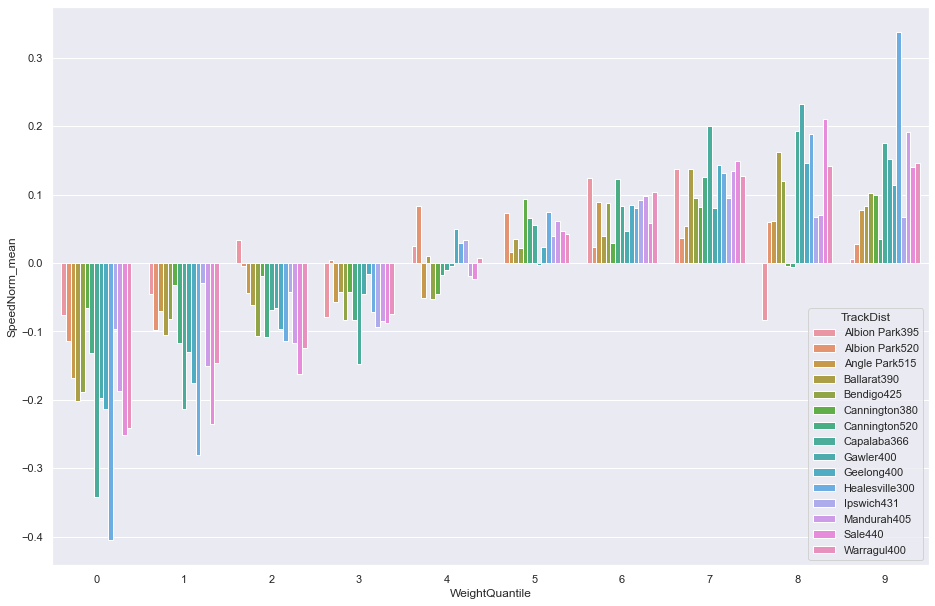

In [7]:
# Plot
sns.set_theme()
fig, ax = plt.subplots(figsize=(15.7, 10.27))
plt.rc('xtick',labelsize=15)
plt.rcParams["axes.labelsize"] = 15
plt.rc('ytick',labelsize=15)
sns.barplot(data=df, x="WeightQuantile", y="SpeedNorm_mean", hue="TrackDist")